In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from imblearn.metrics import classification_report_imbalanced

In [2]:
data = pd.read_csv("data.csv")
labels = pd.read_csv("labels.csv")

In [3]:
data.head()

,Unnamed: 0,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Papillomaviridae.g__Dyolambdapapillomavirus,k__Viruses.o__Mononegavirales.f__Bornaviridae.g__Bornavirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,...,k__Bacteria.p__Synergistetes.c__Synergistia.o__Synergistales.f__Synergistaceae.g__Cloacibacillus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Sellimonas,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Desulfurococcales.f__Desulfurococcaceae.g__Thermosphaera,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum
0,s12859,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,s12878,0,0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,s12857,2,0,484,0,8,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
3,s12882,4,0,96,0,2,0,0,2,4,...,0,0,0,0,0,0,0,0,0,0
4,s12871,2,0,128,0,16,0,4,0,4,...,0,0,0,0,0,0,0,0,0,0


In [4]:
labels.head()

,Sample,disease_type
0,s12859,colon cancer
1,s12878,colon cancer
2,s12857,colon cancer
3,s12882,colon cancer
4,s12871,colon cancer


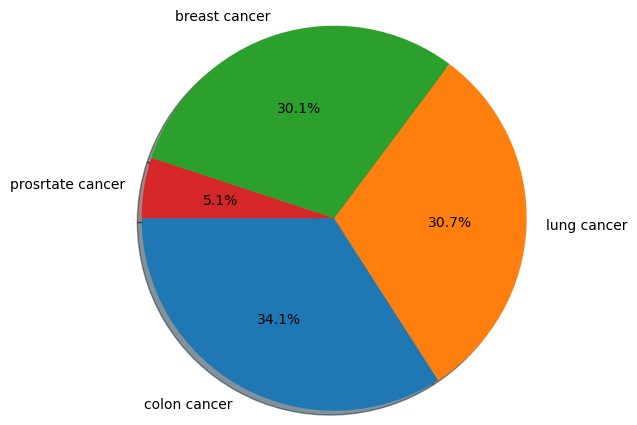

In [5]:
plt.figure( figsize= (5,5))
plt.pie((labels.disease_type.value_counts())/100 , labels=pd.unique(labels.disease_type), startangle
=180 , autopct='%1.1f%%' ,textprops={ 'fontsize': 10 , 'rotation':0}, shadow=True, radius=1.25)
plt.show()

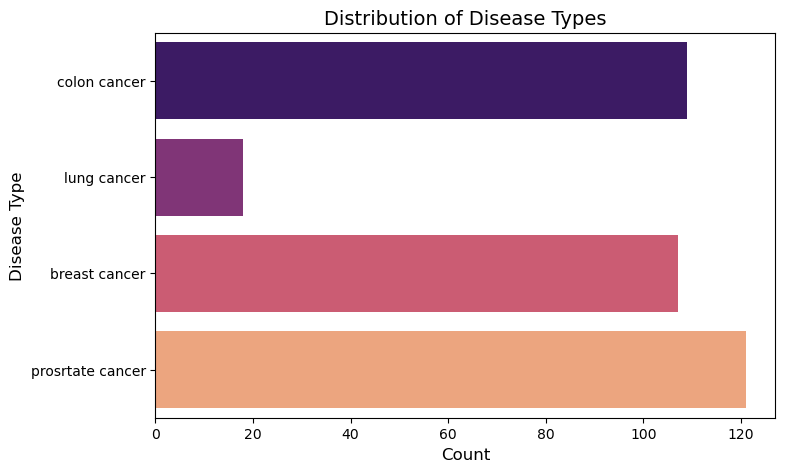

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(y=labels.disease_type, hue=labels.disease_type, palette='magma', dodge=False, legend=False)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Disease Type', fontsize=12)
plt.title('Distribution of Disease Types', fontsize=14)
plt.show()

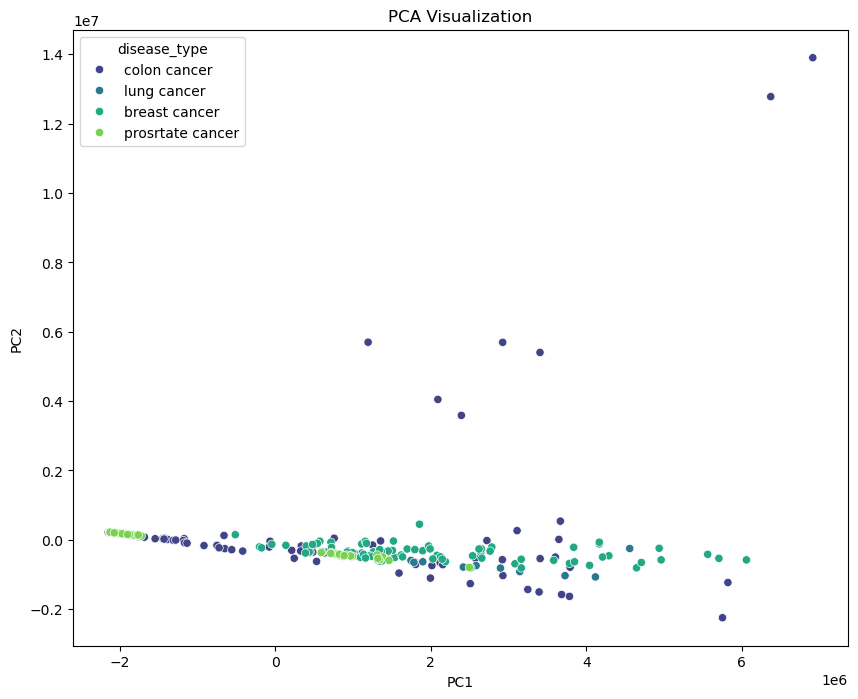

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data.iloc[:, 1:])
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

final_df = pd.concat([principal_df, labels['disease_type']], axis=1)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='disease_type', data=final_df, palette='viridis')
plt.title('PCA Visualization')
plt.show()

# RANDOM FOREST

In [8]:
X = data.drop(['Unnamed: 0'], axis=1)
y = labels.disease_type

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state=42)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rf = RandomForestClassifier()

param_grid = {
     'n_estimators': [50, 100],
    'max_features': [7, 19, 21],
    'min_samples_split': [3, 7, 11],
    'max_depth': [3, 7, 11]
}

In [11]:
# StratifiedKFold kullanarak çapraz doğrulama stratejisini belirle
cv = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk:", grid_search.best_score_)

En iyi parametreler: {'max_depth': 11, 'max_features': 19, 'min_samples_split': 3, 'n_estimators': 100}
En iyi doğruluk: 0.9647256438969766


In [12]:
best_params_rf =  grid_search.best_params_

In [13]:
rf = RandomForestClassifier(max_depth=best_params_rf['max_depth'], 
                            max_features=best_params_rf['max_features'], 
                            min_samples_split=best_params_rf['min_samples_split'], 
                            n_estimators=best_params_rf['n_estimators']).fit(X_train, y_train)

In [14]:
y_pred = rf.predict(X_test)

In [15]:
accuracy_score(y_test, y_pred)

0.9295774647887324

In [16]:
cross_val_score(rf, X_test, y_test, cv=3).mean()

\\?\C:\Users\erens\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


0.8297101449275361

In [17]:
from imblearn.metrics import sensitivity_specificity_support
sensitivity_specificity_support(y_test, y_pred, average='micro', labels=pd.unique(labels.disease_type))

(0.9295774647887324, 0.9765258215962441, None)

In [18]:
print(classification_report_imbalanced(y_test, y_pred, target_names=pd.unique(labels.disease_type)))

                        pre       rec       spe        f1       geo       iba       sup

    colon cancer       1.00      0.72      1.00      0.84      0.85      0.70        18
     lung cancer       0.90      1.00      0.93      0.95      0.97      0.94        26
   breast cancer       1.00      1.00      1.00      1.00      1.00      1.00         2
prosrtate cancer       0.93      1.00      0.96      0.96      0.98      0.96        25

     avg / total       0.94      0.93      0.96      0.93      0.94      0.89        71



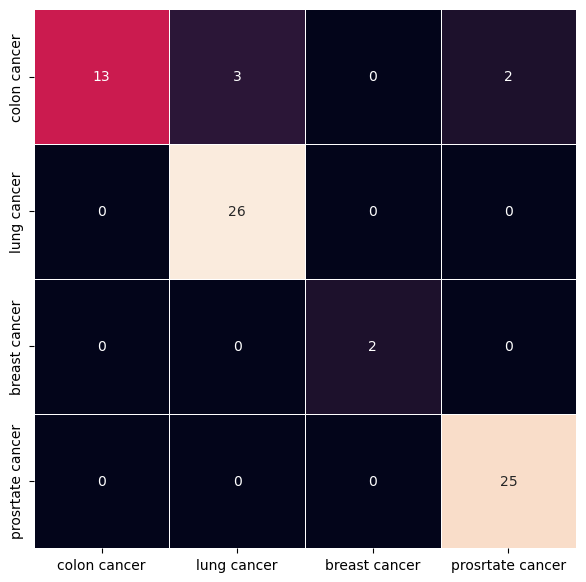

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False, xticklabels=pd.unique(labels.disease_type),yticklabels=pd.unique(labels.disease_type))
plt.show()

# test 

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
gbm_params = {'learning_rate': [0.1, 0.01, 0.05],
            'n_estimators': [100,200],
            'max_depth':[2,3,5,8]}

In [34]:
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [35]:
gbm_cv_model

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [2, 3, 5, 8],
                         'n_estimators': [100, 200]},
             verbose=2)

In [36]:
best_params_gbm = gbm_cv_model.best_params_

In [37]:
gbm = GradientBoostingClassifier(
    learning_rate=best_params_gbm['learning_rate'], 
    max_depth=best_params_gbm['max_depth'], 
    n_estimators=best_params_gbm['n_estimators']).fit(X_train, y_train)

In [38]:
y_pred = gbm.predict(X_test)

In [39]:
accuracy_score(y_test, y_pred)

1.0

# XGBoost

# fix 

print("Gerçek Etiketler:", y_test)
print("Tahminler:", y_pred_single_class)

In [71]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [72]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [73]:
# XGBoost modeli oluşturma
from sklearn.preprocessing import LabelEncoder

# LabelEncoder'ı başlatma
label_encoder = LabelEncoder()

# Hedef değişkeni sayısal olarak kodlama
y_encoded = label_encoder.fit_transform(labels.disease_type)

# Kodlanmış hedef değişkeni kontrol etme
print(y_encoded)

In [ ]:
# GridSearchCV ve XGBoost modeli için eğitim verisini yeniden tanımlama
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# XGBoost modeli oluşturma
xgboost = XGBClassifier()

# Hiperparametre aralıkları
xgboost_params = {'learning_rate': [0.1, 0.01, 0.001],
                  'subsample': [0.6, 0.8, 1],
                  'n_estimators': [100, 500],
                  'max_depth': [3, 5, 7]}

In [ ]:
# GridSearchCV ile modeli eğitme ve hiperparametre optimizasyonu
xgboost_cv_model = GridSearchCV(xgboost, xgboost_params, cv=10, n_jobs=-1, verbose=2)
xgboost_cv_model.fit(X_train, y_train)

# En iyi parametreleri ve doğruluk skorunu gösterme
print("En iyi parametreler:", xgboost_cv_model.best_params_)
print("En iyi doğruluk:", xgboost_cv_model.best_score_)

In [ ]:
# En iyi parametrelerle modeli tekrar eğitme
best_params_xgb = xgboost_cv_model.best_params_
xgboost = XGBClassifier(learning_rate=best_params_xgb['learning_rate'],
                        max_depth=best_params_xgb['max_depth'],
                        n_estimators=best_params_xgb['n_estimators'],
                        subsample=best_params_xgb['subsample'])
xgboost.fit(X_train, y_train)

In [ ]:
# Modelin test verisinde performansını değerlendirme
y_pred = xgboost.predict(X_test)

In [ ]:
# Doğruluk skorunu hesaplama (Alternatif bir değerlendirme metriği seçmek daha iyi olabilir)
accuracy = accuracy_score(y_test, y_pred)
print("Test verisinde doğruluk:", accuracy)


In [40]:
# Cross-validation ile doğruluk skorunu hesaplama
cv_accuracy = cross_val_score(xgboost, X_test, y_test, cv=21).mean()
print("Cross-validation doğruluk:", cv_accuracy)

In [ ]:
from imblearn.metrics import sensitivity_specificity_support
sensitivity_specificity_support(y_test, y_pred, average='micro', labels=pd.unique(labels.disease_type))

In [ ]:
print(classification_report_imbalanced(y_test, y_pred, target_names=pd.unique(labels.disease_type)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False, xticklabels=pd.unique(labels.disease_type),yticklabels=pd.unique(labels.disease_type))
plt.show()

# Conclusion

In [ ]:
models = [rf, xgboost]
result = []
results = pd.DataFrame(columns=['Models', "Accuracy"])

for model in models:
    names = model.__class__.__name__
    print(names)
    if names == 'MLPClassifier':
        y_pred = model.predict(X_test_scaler)
    else:
        y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    result = pd.DataFrame([[names, acc*100]], columns=['Models', 'Accuracy'])
    results = results.append(result)

In [ ]:
sns.barplot(x='Accuracy', y='Models', data=results, color='r')
plt.xlabel('Accuracy %')
plt.title('Modellerin Doğruluk Oranları');

In [ ]:
results